<a href="https://colab.research.google.com/github/TingKaiHsu0525/store/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML HW2 sample code
TODO:
 - Design your CNN model (you are welcomed to use existing models)
 - Hyperparameter tuning

Report:
 - Data Augmentation
 - Draw the confusion matrix

#### Download data


In [ ]:
!gdown 19oEShkdcBJf41nu46anyvu7BgXUffIGi
!unzip -q 'HW2.zip'

Downloading...
From (original): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi
From (redirected): https://drive.google.com/uc?id=19oEShkdcBJf41nu46anyvu7BgXUffIGi&confirm=t&uuid=c44a558c-6724-4cf3-bba0-f0bf77abd48f
To: /content/HW2.zip
100% 52.1M/52.1M [00:00<00:00, 175MB/s]


#### Import packages

In [ ]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

#### Hyperparameters and setting

In [ ]:
# TODO: modify the hyperparameters
config = Namespace(
    random_seed = 42,
    BATCH = 128,
    n_epoch = 20, #50
    lr = 1e-4, #1e-4
    weight_decay = 0.9, #1e-7
    ckpt_path = 'model.pth',
)

In [ ]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
random.seed(config.random_seed)
np.random.seed(config.random_seed)

#### Dataset and Dataloader

In [ ]:
class FaceExpressionDataset(Dataset):
    def __init__(self, img_path, label_path=None, tfm=T.ToTensor()):
        n_samples = len(os.listdir(img_path))
        if label_path is not None:
            self.images = [f'{img_path}/{i+7000}.jpg' for i in range(n_samples)]
            self.labels = pd.read_csv(label_path)['label'].values.tolist()
        else:
            self.images = [f'{img_path}/{i}.jpg' for i in range(n_samples)]
            self.labels = None
        self.tfm = tfm

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.tfm(img)
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __len__(self):
        return len(self.images)

In [ ]:
# TODO: define your augmentation for training and evaluation
train_tfm = T.Compose([
    # ...
    T.ToTensor(),
])
eval_tfm = T.Compose([
    # ...
    T.ToTensor(),
])

# Data Augmentation

In [ ]:
# Augmentation for training
train_tfm = T.Compose([
    T.RandomHorizontalFlip(p=0.5),  # 以50%的機率水平翻轉
    T.GaussianBlur(kernel_size=3, sigma=(0.1)), # 高斯模糊
    T.ColorJitter(brightness=0.3, contrast=0.4),  # 只調整亮度和對比度 , contrast=0.4
    T.RandomRotation(degrees=15),   # 隨機旋轉影像，範圍在-15到+15度
    T.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),  # 隨機裁剪並調整為64x64大小
    T.ToTensor(),  # 轉換為張量
])


# Augmentation for evaluation following train
eval_tfm = T.Compose([
    T.ToTensor(),  # 轉換為張量

])

In [ ]:
# dataset
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=train_tfm)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)
# dataloader
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


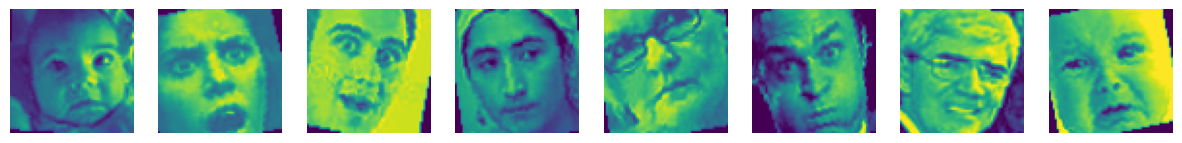

In [ ]:
# Function to display a batch of images
def show_batch(dl, n_images=8):
    batch = next(iter(dl))  # Get a batch of data
    images, labels = batch
    images = images[:n_images]  # Select the first n images in the batch

    # Create a grid to display images
    fig, axs = plt.subplots(1, n_images, figsize=(15, 5))

    for i in range(n_images):
        img = images[i].permute(1, 2, 0)  # Convert tensor to image format
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.show()

# Display a batch of augmented images from the training loader
show_batch(train_loader)


#### Model

In [ ]:
# TODO: define your CNN model
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )

        self.fc = nn.Sequential(
            nn.Linear( 32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc(x)
        return x

#### training loop

In [ ]:
def train(model, train_loader, valid_loader, config):
    model.to(device)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_acc = 0
    train_losses, valid_losses = [], []
    for epoch in range(config.n_epoch):
        # train
        model.train()
        train_loss, train_acc = 0, 0
        for img, lab in tqdm(train_loader):
            img, lab = img.to(device), lab.to(device)
            output = model(img)
            optimizer.zero_grad()
            loss = criteria(output, lab)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        train_losses.append(train_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

        # valid
        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, lab in valid_loader:
                img, lab = img.to(device), lab.to(device)
                output = model(img)
                loss = criteria(output, lab)
                valid_loss += loss.item()
                valid_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        valid_loss, valid_acc = valid_loss/len(valid_loader), valid_acc/len(valid_loader)
        valid_losses.append(valid_loss)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

        # update
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), config.ckpt_path)
            print(f'== best valid acc: {best_acc:.4f} ==')
    model.load_state_dict(torch.load(config.ckpt_path))

    # plot the training/validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(config.n_epoch), train_losses, label='Training Loss')
    plt.plot(range(config.n_epoch), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Pre-trained model

In [ ]:
from torchvision import models

# 載入預訓練的 ResNet18 模型
Pre_train_model = models.resnet18(pretrained=True)


# 修改第一個卷積層以接受 1 通道的輸入
Pre_train_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

# 修改 ResNet 的最後一層
num_ftrs = Pre_train_model.fc.in_features

Pre_train_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 7)
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


### Training

## BY Pre_trained

100%|██████████| 181/181 [00:42<00:00,  4.22it/s]


Epoch: 1/20, train loss: 1.6095, train acc: 0.3540
Epoch: 1/20, valid loss: 1.3319, valid acc: 0.4843
== best valid acc: 0.4843 ==


100%|██████████| 181/181 [00:38<00:00,  4.65it/s]


Epoch: 2/20, train loss: 1.2315, train acc: 0.5367
Epoch: 2/20, valid loss: 1.1690, valid acc: 0.5618
== best valid acc: 0.5618 ==


100%|██████████| 181/181 [00:38<00:00,  4.69it/s]


Epoch: 3/20, train loss: 1.1059, train acc: 0.5832
Epoch: 3/20, valid loss: 1.1290, valid acc: 0.5682
== best valid acc: 0.5682 ==


100%|██████████| 181/181 [00:37<00:00,  4.78it/s]


Epoch: 4/20, train loss: 1.0350, train acc: 0.6150
Epoch: 4/20, valid loss: 1.0584, valid acc: 0.6026
== best valid acc: 0.6026 ==


100%|██████████| 181/181 [00:38<00:00,  4.71it/s]


Epoch: 5/20, train loss: 0.9822, train acc: 0.6327
Epoch: 5/20, valid loss: 1.0378, valid acc: 0.6082
== best valid acc: 0.6082 ==


100%|██████████| 181/181 [00:38<00:00,  4.72it/s]


Epoch: 6/20, train loss: 0.9309, train acc: 0.6506
Epoch: 6/20, valid loss: 1.0162, valid acc: 0.6116
== best valid acc: 0.6116 ==


100%|██████████| 181/181 [00:38<00:00,  4.65it/s]


Epoch: 7/20, train loss: 0.8946, train acc: 0.6661
Epoch: 7/20, valid loss: 1.0245, valid acc: 0.6182
== best valid acc: 0.6182 ==


100%|██████████| 181/181 [00:39<00:00,  4.62it/s]


Epoch: 8/20, train loss: 0.8528, train acc: 0.6861
Epoch: 8/20, valid loss: 1.0001, valid acc: 0.6268
== best valid acc: 0.6268 ==


100%|██████████| 181/181 [00:37<00:00,  4.84it/s]


Epoch: 9/20, train loss: 0.8154, train acc: 0.7015
Epoch: 9/20, valid loss: 1.0167, valid acc: 0.6187


100%|██████████| 181/181 [00:38<00:00,  4.66it/s]


Epoch: 10/20, train loss: 0.7843, train acc: 0.7082
Epoch: 10/20, valid loss: 1.0073, valid acc: 0.6346
== best valid acc: 0.6346 ==


100%|██████████| 181/181 [00:37<00:00,  4.88it/s]


Epoch: 11/20, train loss: 0.7447, train acc: 0.7290
Epoch: 11/20, valid loss: 1.0315, valid acc: 0.6217


100%|██████████| 181/181 [00:38<00:00,  4.65it/s]


Epoch: 12/20, train loss: 0.7120, train acc: 0.7371
Epoch: 12/20, valid loss: 1.0282, valid acc: 0.6299


100%|██████████| 181/181 [00:39<00:00,  4.63it/s]


Epoch: 13/20, train loss: 0.6735, train acc: 0.7520
Epoch: 13/20, valid loss: 1.0796, valid acc: 0.6249


100%|██████████| 181/181 [00:39<00:00,  4.57it/s]


Epoch: 14/20, train loss: 0.6430, train acc: 0.7632
Epoch: 14/20, valid loss: 1.0402, valid acc: 0.6393
== best valid acc: 0.6393 ==


100%|██████████| 181/181 [00:39<00:00,  4.58it/s]


Epoch: 15/20, train loss: 0.6087, train acc: 0.7781
Epoch: 15/20, valid loss: 1.0620, valid acc: 0.6269


100%|██████████| 181/181 [00:39<00:00,  4.57it/s]


Epoch: 16/20, train loss: 0.5850, train acc: 0.7865
Epoch: 16/20, valid loss: 1.1031, valid acc: 0.6279


100%|██████████| 181/181 [00:37<00:00,  4.77it/s]


Epoch: 17/20, train loss: 0.5469, train acc: 0.8030
Epoch: 17/20, valid loss: 1.0698, valid acc: 0.6353


100%|██████████| 181/181 [00:39<00:00,  4.60it/s]


Epoch: 18/20, train loss: 0.5244, train acc: 0.8114
Epoch: 18/20, valid loss: 1.1210, valid acc: 0.6364


100%|██████████| 181/181 [00:38<00:00,  4.71it/s]


Epoch: 19/20, train loss: 0.5020, train acc: 0.8180
Epoch: 19/20, valid loss: 1.0888, valid acc: 0.6455
== best valid acc: 0.6455 ==


100%|██████████| 181/181 [00:38<00:00,  4.66it/s]


Epoch: 20/20, train loss: 0.4730, train acc: 0.8308
Epoch: 20/20, valid loss: 1.1055, valid acc: 0.6329


<ipython-input-9-a166fffb6795>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config.ckpt_path))


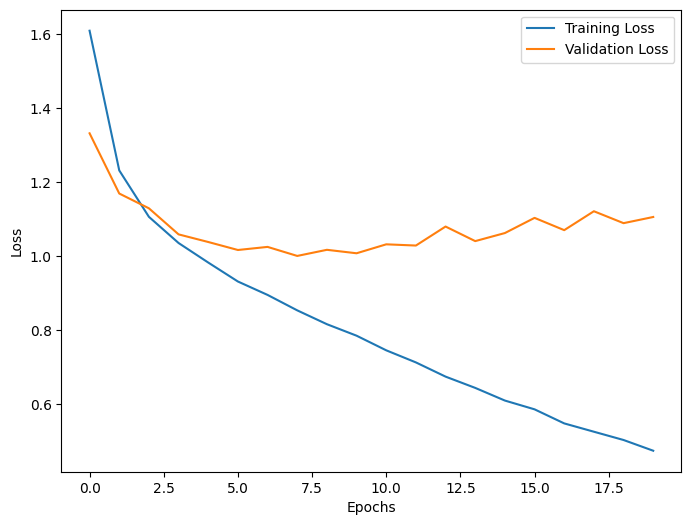

In [ ]:
#model = FaceExpressionNet()
train(Pre_train_model, train_loader, valid_loader, config)

100%|██████████| 46/46 [00:13<00:00,  3.40it/s]


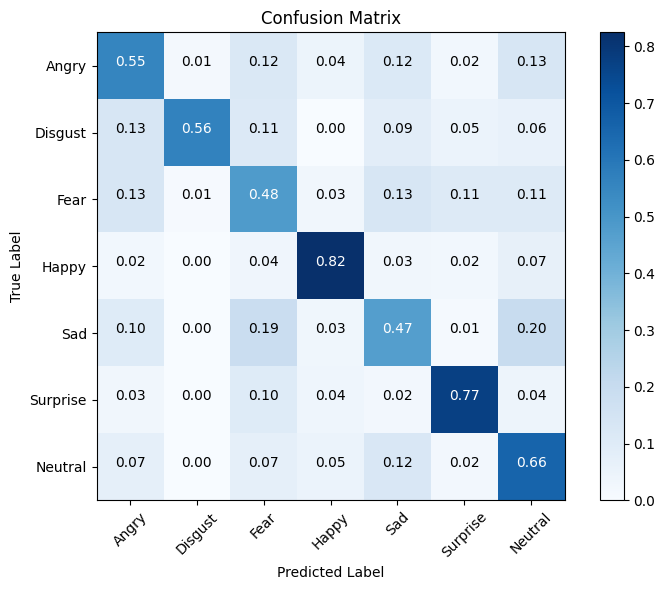

In [ ]:
def draw_confusion_matrix(model, valid_loader, class_names):
    predictions, labels = [], []
    model.to(device)
    model.eval()

    # Collecting predictions and true labels
    with torch.no_grad():
        for img, lab in tqdm(valid_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
            labels += lab.tolist()

    # Number of classes
    num_classes = len(class_names)

    # TODO draw the confusion matrix

    # Confusion matrix
    cm = np.zeros((num_classes, num_classes), dtype=np.int32)
    for t, p in zip(labels, predictions):
        cm[t, p] += 1

    # Normalize by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plotting the confusion matrix using matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add text annotations
    fmt = '.2f'  # Format for displaying percentages
    thresh = cm_normalized.max() / 2.  # Threshold to determine text color
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            plt.text(j, i, format(cm_normalized[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm_normalized[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Assuming you have your pre-trained model and valid_loader ready
draw_confusion_matrix(Pre_train_model, valid_loader, class_names)

### Testing

In [ ]:
def test(model, test_loader):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
    with open('predict.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in enumerate(predictions):
            writer.writerow([id, r])

In [ ]:
Pre_train_model.load_state_dict(torch.load('model.pth'))
test(Pre_train_model, test_loader)

<ipython-input-14-da74fa3b5b4d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Pre_train_model.load_state_dict(torch.load('model.pth'))
100%|██████████| 55/55 [00:04<00:00